In [11]:
import os
os.chdir("/home/imendoza/deblend/galaxy-net")
import sys
sys.path.insert(0, "/home/imendoza/deblend/galaxy-net")
sys.path.insert(0, "/home/imendoza/deblend/galaxy-net/WeakLensingDeblending")
sys.path.insert(0, "/home/imendoza/deblend/galaxy-net/BlendingToolKit")

import numpy as np
import btk
import btk.config, btk.plot_utils
import fitsio as fits
import matplotlib.pyplot as plt
from importlib import reload

print(os.getcwd())

/home/imendoza/deblend/galaxy-net


# Histograms (catalog)

In [95]:
catalog_name = os.path.join(os.getcwd(), 'params', 'OneDegSq.fits')
cat = fits.read(catalog_name)
param_names = ['ra', 'dec', 'redshift',
                            'fluxnorm_bulge', 'fluxnorm_disk', 'fluxnorm_agn',
                            'a_b', 'a_d', 'b_b', 'b_d', 'pa_bulge', 'pa_disk',
                            'u_ab', 'g_ab', 'r_ab', 'i_ab', 'z_ab', 'y_ab']

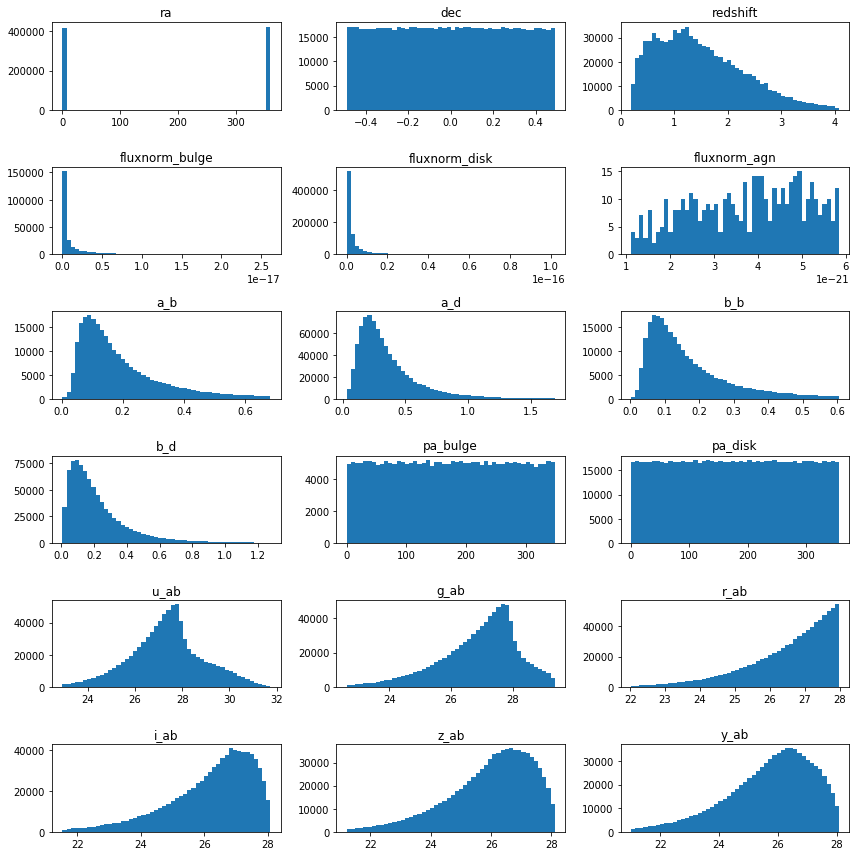

In [96]:
fig, axes = plt.subplots(ncols=3,nrows=6, figsize=(12,12))
axs = axes.flatten()
for param, ax in zip(param_names, axs):
    ax.set_title(param)
    q1 = np.quantile(cat[param], 0.01)
    q2 = np.quantile(cat[param], 0.99)
    keep = (cat[param]>q1) & (cat[param] < q2)
    ax.hist(cat[keep][param], bins=50)
plt.tight_layout()


# Compare with the catalog net 

In [12]:
import catalog_net
import datasets
import torch
import train_catalog
from torch.distributions import Normal
reload(catalog_net)

<module 'catalog_net' from '/home/imendoza/deblend/galaxy-net/catalog_net.py'>

In [13]:
ds = datasets.CatsimData()
vae = catalog_net.catalogNet(ds.num_params, latent_dim=50)
train_module = train_catalog.Traincatalog(latent_dim=50)
vae.load_state_dict(torch.load("/home/imendoza/deblend/galaxy-net/data/test_cat2/params/vae_params_90.dat"))

<All keys matched successfully>

In [14]:
vae.cuda()
vae.eval();


In [138]:
for sample in train_module.train_loader:
    break
sample.shape #just to see how the size is formatted. 
z_mean, z_var = vae.enc.forward(sample.cuda())  # shape = [nsamples, latent_dim]
q_z = Normal(z_mean, z_var.sqrt())
z = q_z.rsample()
z.shape


torch.Size([64, 20])

In [16]:
# z_mean, z_var = vae.enc.forward(data) 
samples = [] 
for i in range(10000):
    p_z = Normal(vae.zero, vae.one)
    z = p_z.rsample(torch.Size([vae.latent_dim])).view(1,50)
    recon_mean, recon_var = vae.dec.forward(z)
    samples.append(recon_mean)


In [183]:
print(ds[5])

[1.2105684e+00 0.0000000e+00 9.6251098e-19 0.0000000e+00 0.0000000e+00
 4.0511450e-01 0.0000000e+00 1.2158950e-01 7.8123459e+01 2.6886911e+01
 2.7252081e+01 2.6939846e+01 2.6891243e+01 2.6636051e+01 2.6566887e+01]


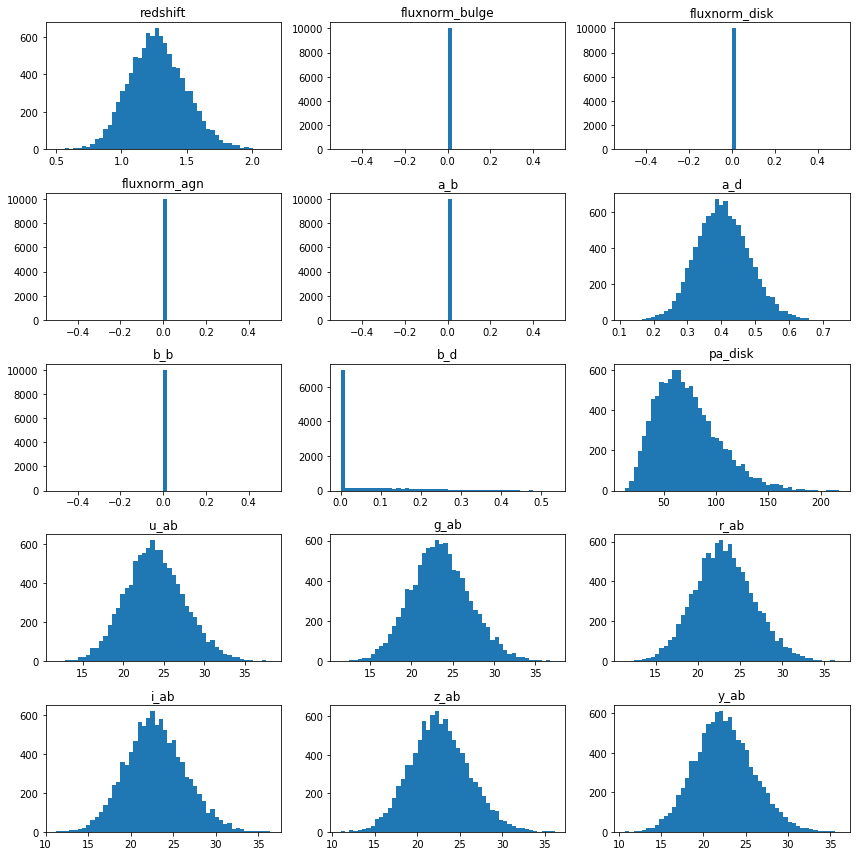

In [17]:
fig,axes = plt.subplots(ncols=3, nrows=5, figsize=(12,12))
axs = axes.flatten()
for i, param in enumerate(ds.param_names):
    ax = axs[i]
    param_vals = [sample.cpu().detach().numpy()[0][i] for sample in samples]
    ax.set_title(param)
    ax.hist(param_vals, bins=50)
plt.tight_layout()


In [228]:
samples[0].cpu().detach().numpy()[0][0]

0.92471313

# BTK

In [2]:
def new_center_shift(Args, number_of_objects):
    """Shift galaxy centers with a value drawn from a normal distribution with
    mean 0 and std 1 arcseconds."""
    mean, sigma = 0, 1 #arcseconds
    dx = np.random.normal(mean, sigma, number_of_objects)
    dy = np.random.normal(mean, sigma, number_of_objects)
    return dx, dy
    
def new_sampling_function(Args, catalog):
    """Returns catalog with parametrs to draw one blend scene.
    
    Samples galaxies with i<24, r-i>1. Number of objects ber blend is selected from a poisson
    distribution of mean 3. The number of objects is restricted to max_number. The centers of the objects 
    are set in new function new_center_shift().
    Note:Sampling function must clip the number of objects to Args.max_number!
    """
    # Determine number of objets per blend
    number_of_objects = np.random.poisson(3)
    number_of_objects = np.minimum(number_of_objects, Args.max_number)
    
    # Make galaxy sample
    q, = np.where((catalog['i_ab'] <= 25.3) & (np.abs(catalog['i_ab'] - catalog['r_ab']) > 0.5))
    blend_catalog = catalog[np.random.choice(q, size=number_of_objects)]
    
    # galaxy centers are sent as random shift from 0,0
    blend_catalog['ra'], blend_catalog['dec'] = 0., 0.
    dx, dy = new_center_shift(Args, number_of_objects)
    blend_catalog['ra'] += dx
    blend_catalog['dec'] += dy
    return blend_catalog

In [49]:
catalog_name = os.path.join(os.getcwd(), 'params', 'OneDegSq.fits')
print(catalog_name)

# Load parameters
param = btk.config.Simulation_params(catalog_name, max_number=1, batch_size=1)
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catalog(param)

/home/imendoza/deblend/galaxy-net/params/OneDegSq.fits


astropy.table.table.Table

In [69]:
catalog.columns.keys()

['galtileid',
 'ra',
 'dec',
 'redshift',
 'fluxnorm_bulge',
 'fluxnorm_disk',
 'fluxnorm_agn',
 'a_b',
 'a_d',
 'b_b',
 'b_d',
 'pa_bulge',
 'pa_disk',
 'u_ab',
 'g_ab',
 'r_ab',
 'i_ab',
 'z_ab',
 'y_ab']

In [23]:
#Generate catalogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog, new_sampling_function)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator)


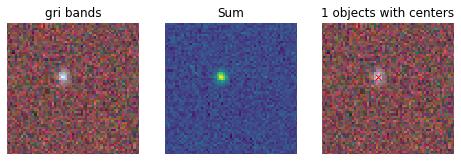

CPU times: user 2.16 s, sys: 75.9 ms, total: 2.23 s
Wall time: 329 ms


In [47]:
%%time
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(30,90),band_indices=[1,2,3])

In [41]:
blend_images.shape


(1, 120, 120, 6)